In [49]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.simplefilter('ignore')
from sklearn.impute import KNNImputer
from docx import Document
from sklearn.impute import SimpleImputer

In [50]:
masterList= {"Fruits and Nuts":['Apples', 'Apricots', 'Cherries', 'Currants', 'Gooseberries', 'Grapes', 'Peaches and nectarines', 'Pears', 'Plums and sloes', 'Raspberries', 'Sour cherries', 'Strawberries', 
                                       'Walnuts, in shell', 'Blueberries', 'Other stone fruits', 'Other berries and fruits of the genus vaccinium n.e.c.'],
            "Vegetables and Legumes":['Asparagus', 'Broad beans and horse beans, dry', 'Broad beans and horse beans, green', 'Beans, dry', 'Cabbages', 'Carrots and turnips', 'Cauliflowers and broccoli', 
                                                    'Cucumbers and gherkins', 'Lentils, dry', 'Lettuce and chicory', 'Lupins', 'Other beans, green', 'Other pulses n.e.c.', 'Other vegetables, fresh n.e.c.', 'Peas, dry', 
                                                    'Peas, green', 'Potatoes', 'Spinach', 'Sugar beet', 'Tomatoes', 'Leeks and other alliaceous vegetables', 'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)', 
                                                    'Pumpkins, squash and gourds', 'Onions and shallots, green', 'Onions and shallots, dry (excluding dehydrated)'],
             "Cereals":['Barley', 'Maize (corn)', 'Mixed grain', 'Oats', 'Rye', 'Triticale', 'Wheat'],
             "Industrial_crops" :['Mustard seed', 'Other oil seeds, n.e.c.', 'Poppy seed', 'Rape or colza seed', 'Sunflower seed', 'Soya beans', 'Linseed','Hop cones','Vetches', 'Unmanufactured tobacco']}

In [51]:
fruits_season = {
    "Spring": ["Apricots", "Cherries", "Gooseberries", "Raspberries", "Strawberries"],
    "Summer": ["Apples", "Currants", "Grapes", "Peaches and nectarines", "Pears", "Plums and sloes", "Sour cherries", "Blueberries"],
    "Autumn": ["Walnuts, in shell"],
    "Year-Round": ["Other stone fruits", "Other berries and fruits of the genus vaccinium n.e.c."]
}
vegetable_season = {
    'Spring': ['Asparagus', 'Cabbages', 'Lettuce and chicory', 'Spinach', 'Broad beans and horse beans, green', 'Carrots and turnips', 'Peas, green', 'Onions and shallots, green'],
    'Summer': ['Cucumbers and gherkins', 'Tomatoes', 'Lettuce and chicory', 'Broad beans and horse beans, green', 'Peas, green', 'Onions and shallots, green'],
    'Fall': ['Cabbages', 'Carrots and turnips', 'Cauliflowers and broccoli', 'Leeks and other alliaceous vegetables', 'Onions and shallots, dry (excluding dehydrated)', 'Pumpkins, squash and gourds', 'Peas, dry'],
    'Winter': ['Cabbages', 'Carrots and turnips', 'Onions and shallots, dry (excluding dehydrated)', 'Potatoes', 'Spinach', 'Peas, dry'],
    'Year-Round': ['Beans, dry', 'Broad beans and horse beans, dry', 'Lentils, dry', 'Other beans, green', 'Other pulses n.e.c.', 'Other vegetables, fresh n.e.c.', 'Sugar beet', 'Chillies and peppers, green (Capsicum spp. and Pimenta spp.)', 'Lupins']
}
crop_dict = {
    'Spring': ['Barley', 'Oats'],
    'Summer': ['Maize (corn)'],
    'Autumn': ['Mixed grain', 'Rye', 'Triticale', 'Wheat']
}
industrial_crops = {
    'Spring': {
        'Mustard seed',
        'Other oil seeds (n.e.c.)',
        'Poppy seed',
        'Rape or colza seed',
        'Soya beans',
        'Hop cones',
        'Vetches'
    },
    'Summer': {
        'Sunflower seed',
        'Linseed'
    },
    'Year-Round': {
        'Unmanufactured tobacco'
    }
}

In [52]:
combined_dict = {}

# Combine all values from fruits_season, vegetable_season, crop_dict and industrial_crops into combined_dict
for d in [fruits_season, vegetable_season, crop_dict, industrial_crops]:
    for k, v in d.items():
        if k in combined_dict:
            combined_dict[k].extend(v)
        else:
            combined_dict[k] = v

# Print the combined dictionary
print(combined_dict)

{'Spring': ['Apricots', 'Cherries', 'Gooseberries', 'Raspberries', 'Strawberries', 'Asparagus', 'Cabbages', 'Lettuce and chicory', 'Spinach', 'Broad beans and horse beans, green', 'Carrots and turnips', 'Peas, green', 'Onions and shallots, green', 'Barley', 'Oats', 'Hop cones', 'Soya beans', 'Mustard seed', 'Vetches', 'Other oil seeds (n.e.c.)', 'Rape or colza seed', 'Poppy seed'], 'Summer': ['Apples', 'Currants', 'Grapes', 'Peaches and nectarines', 'Pears', 'Plums and sloes', 'Sour cherries', 'Blueberries', 'Cucumbers and gherkins', 'Tomatoes', 'Lettuce and chicory', 'Broad beans and horse beans, green', 'Peas, green', 'Onions and shallots, green', 'Maize (corn)', 'Linseed', 'Sunflower seed'], 'Autumn': ['Walnuts, in shell', 'Mixed grain', 'Rye', 'Triticale', 'Wheat'], 'Year-Round': ['Other stone fruits', 'Other berries and fruits of the genus vaccinium n.e.c.', 'Beans, dry', 'Broad beans and horse beans, dry', 'Lentils, dry', 'Other beans, green', 'Other pulses n.e.c.', 'Other vegeta

In [53]:
fao_data = pd.read_csv("datasets/master_data_processed.csv")
del fao_data['Unnamed: 0']
list(fao_data.columns)

['Year',
 'Nutrient nitrogen N (total) - tonnes',
 'Nutrient phosphate P2O5 (total) - tonnes',
 'Nutrient potash K2O (total) - tonnes',
 'Item',
 'Yield(tonnes/ha)',
 'Fung & Bact – Benzimidazoles',
 'Fung & Bact – Diazines, morpholines',
 'Fung & Bact – Dithiocarbamates',
 'Fung & Bact – Inorganics',
 'Fung & Bact – Other',
 'Fung & Bact – Triazoles, diazoles',
 'Herbicides – Amides',
 'Herbicides – Carbamates',
 'Herbicides – Dinitroanilines',
 'Herbicides – Other',
 'Herbicides – Phenoxy hormone products',
 'Herbicides – Triazines',
 'Herbicides – Urea derivates',
 'Insecticides – Botanical products and biologicals',
 'Insecticides – Carbamates',
 'Insecticides – Organo-phosphates',
 'Insecticides – Other',
 'Insecticides – Pyrethroids',
 'Mineral Oils',
 'Plant Growth Regulators',
 'Rodenticides – Other',
 'Herbicides – Bipiridils',
 'Herbicides – Sulfonyl ureas',
 'Rodenticides – Anti-coagulants']

In [54]:
len(fao_data['Item'].value_counts())

57

In [55]:
# Define a lambda function to apply the condition
category_func = lambda x: next((k for k, v in masterList.items() if x in v), None)

# Apply the lambda function to create new column
fao_data['Category'] = fao_data['Item'].apply(category_func)

In [56]:
# Define a lambda function to apply the condition
season_func = lambda x: next((k for k, v in combined_dict.items() if x in v), None)

# Apply the lambda function to create new column
fao_data['Crop_season'] = fao_data['Item'].apply(season_func)


In [57]:
fao_data['Category'].value_counts()

Vegetables and Legumes    670
Fruits and Nuts           450
Industrial_crops          237
Cereals                   217
Name: Category, dtype: int64

In [58]:
fao_data['Crop_season'].value_counts()

Spring        591
Summer        381
Year-Round    274
Autumn        152
Fall          145
Winter         31
Name: Crop_season, dtype: int64

In [59]:
df = fao_data
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.reset_index(drop=True, inplace=True)
df.set_index("Year", inplace=True)
df.index.name = None
df

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Insecticides – Other,Insecticides – Pyrethroids,Mineral Oils,Plant Growth Regulators,Rodenticides – Other,Herbicides – Bipiridils,Herbicides – Sulfonyl ureas,Rodenticides – Anti-coagulants,Category,Crop_season
1990-01-01,1787300,609000,954400,Apples,26.3272,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Fruits and Nuts,Summer
1990-01-01,1787300,609000,954400,Apricots,2.5781,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Fruits and Nuts,Spring
1990-01-01,1787300,609000,954400,Asparagus,2.7611,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Vegetables and Legumes,Spring
1990-01-01,1787300,609000,954400,Barley,5.3558,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Cereals,Spring
1990-01-01,1787300,609000,954400,"Beans, dry",3.0736,215.0,1047.0,2828.0,2466.0,2670.0,...,396.0,113.0,642.0,1910.0,8.0,139.766667,41.6,5.0,Vegetables and Legumes,Year-Round
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,1265477,192182,446396,Sugar beet,74.1402,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Vegetables and Legumes,Year-Round
2020-01-01,1265477,192182,446396,Sunflower seed,2.0567,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Industrial_crops,Summer
2020-01-01,1265477,192182,446396,Tomatoes,268.7368,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Vegetables and Legumes,Summer
2020-01-01,1265477,192182,446396,Triticale,5.9663,32.0,52.0,1655.0,2851.0,3180.0,...,20739.0,121.0,359.0,2233.0,16.0,0.000000,134.0,0.1,Cereals,Autumn


In [60]:
df["Item"].unique()

array(['Apples', 'Apricots', 'Asparagus', 'Barley', 'Beans, dry',
       'Broad beans and horse beans, dry',
       'Broad beans and horse beans, green', 'Cabbages',
       'Carrots and turnips', 'Cauliflowers and broccoli', 'Cherries',
       'Cucumbers and gherkins', 'Currants', 'Gooseberries', 'Grapes',
       'Hop cones', 'Leeks and other alliaceous vegetables',
       'Lentils, dry', 'Lettuce and chicory', 'Lupins', 'Maize (corn)',
       'Mixed grain', 'Mustard seed', 'Oats',
       'Onions and shallots, dry (excluding dehydrated)',
       'Other beans, green', 'Other pulses n.e.c.',
       'Other vegetables, fresh n.e.c.', 'Peaches and nectarines',
       'Pears', 'Peas, dry', 'Peas, green', 'Plums and sloes',
       'Poppy seed', 'Potatoes', 'Rape or colza seed', 'Raspberries',
       'Rye', 'Sour cherries', 'Soya beans', 'Spinach', 'Strawberries',
       'Sugar beet', 'Sunflower seed', 'Tomatoes', 'Triticale',
       'Unmanufactured tobacco', 'Vetches', 'Walnuts, in shell', 'W

In [61]:
# doc = Document()
# B = pd.DataFrame(columns=['column_name', 'datatype', 'unique_value_count'])

# for col in fao_data.columns:
#     col_type = str(fao_data[col].dtype)
#     unique_count = fao_data[col].nunique()
#     B = B.append({'column_name': col, 'datatype': col_type, 'unique_value_count': unique_count}, ignore_index=True)

# B
# # create a Word document and add a table to it
# doc = Document()
# table = doc.add_table(rows=1, cols=4)
# hdr_cells = table.rows[0].cells
# hdr_cells[0].text = 'Column Name'
# hdr_cells[1].text = 'Data Type'
# hdr_cells[2].text = 'Unique Values'
# hdr_cells[3].text = 'Description'

# # add the rows from the dataframe to the table
# for i, row in B.iterrows():
#     cells = table.add_row().cells
#     cells[0].text = row['column_name']
#     cells[1].text = row['datatype']
#     cells[2].text = str(row['unique_value_count'])

# # save the Word document
# doc.save('prepresult.docx')


In [62]:
cat_names = df['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals',
       'Industrial_crops'], dtype=object)

In [63]:
stat = {}
non_stat = {}

for cate in cat_names:
    crop_df = df[df["Category"] == cate ]
    non_st = []
    st = []
    for col in crop_df.select_dtypes(include=[np.number]):
        # perform ADF test to check stationarity
        adf_result = adfuller(crop_df[col])
    
        if adf_result[1] > 0.05:
            #print ('Time series is NOT stationary')
            non_st.append(col)  
        else:
            #print ('Time series is stationary')
            st.append(col)
    non_stat[cate] = non_st
    stat[cate] = st


print("Stationary:", stat)
print("Not Stationary:", non_stat)
print(len(stat))
print(len(non_st))
#pd.DataFrame(stat)

Stationary: {'Fruits and Nuts': ['Yield(tonnes/ha)', 'Herbicides – Dinitroanilines', 'Insecticides – Botanical products and biologicals', 'Insecticides – Carbamates', 'Insecticides – Organo-phosphates', 'Plant Growth Regulators', 'Rodenticides – Anti-coagulants'], 'Vegetables and Legumes': ['Nutrient potash K2O (total) - tonnes', 'Yield(tonnes/ha)', 'Fung & Bact – Inorganics', 'Herbicides – Dinitroanilines', 'Herbicides – Other', 'Insecticides – Botanical products and biologicals', 'Insecticides – Carbamates', 'Plant Growth Regulators', 'Herbicides – Sulfonyl ureas', 'Rodenticides – Anti-coagulants'], 'Cereals': ['Herbicides – Dinitroanilines', 'Insecticides – Organo-phosphates', 'Rodenticides – Anti-coagulants'], 'Industrial_crops': ['Herbicides – Dinitroanilines', 'Insecticides – Botanical products and biologicals', 'Insecticides – Carbamates', 'Plant Growth Regulators', 'Rodenticides – Anti-coagulants']}
Not Stationary: {'Fruits and Nuts': ['Nutrient nitrogen N (total) - tonnes', 'N

In [64]:
for i in stat.keys():
    print(i, len(stat[i]))

Fruits and Nuts 7
Vegetables and Legumes 10
Cereals 3
Industrial_crops 5


In [65]:
for i in non_stat.keys():
    print(i, len(non_stat[i]))

Fruits and Nuts 21
Vegetables and Legumes 18
Cereals 25
Industrial_crops 23


In [66]:
imputer = KNNImputer(n_neighbors=4)
adf_df = pd.DataFrame(columns=df.columns)

for cate in cat_names: 
    # Selects category
    crop_df = df[df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    # Selects column for ADF Test
    for col in num_cols:
        if crop_df[col].count() < 5:
            continue
        adf_result = adfuller(crop_df[col])
        while adf_result[1] > 0.05:
            crop_df[col] = crop_df[col].diff()
            crop_df[num_cols.columns] = imputer.fit_transform(crop_df[num_cols.columns])
            adf_result = adfuller(crop_df[col])

    adf_df = pd.concat([adf_df, crop_df])

adf_df
    

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Insecticides – Other,Insecticides – Pyrethroids,Mineral Oils,Plant Growth Regulators,Rodenticides – Other,Herbicides – Bipiridils,Herbicides – Sulfonyl ureas,Rodenticides – Anti-coagulants,Category,Crop_season
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1910.0,0.0,0.0,0.0,5.00,Fruits and Nuts,Summer
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1910.0,0.0,0.0,0.0,5.00,Fruits and Nuts,Spring
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1910.0,0.0,0.0,0.0,5.00,Fruits and Nuts,Spring
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1910.0,0.0,0.0,0.0,5.00,Fruits and Nuts,Summer
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1910.0,0.0,0.0,0.0,5.00,Fruits and Nuts,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,0.0,0.0,0.0,Sunflower seed,-0.8656,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2089.0,0.0,0.0,0.0,0.41,Industrial_crops,Summer
2020-01-01,-106607.0,-55584.0,26854.0,Hop cones,0.2323,-15.0,-241.0,142.0,140.0,-773.0,...,2548.0,8.0,239.0,2233.0,6.0,-84.0,4.0,0.10,Industrial_crops,Spring
2020-01-01,0.0,0.0,0.0,Rape or colza seed,1.4064,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2233.0,0.0,0.0,0.0,0.10,Industrial_crops,Spring
2020-01-01,0.0,0.0,0.0,Soya beans,-1.0056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2233.0,0.0,0.0,0.0,0.10,Industrial_crops,Spring


In [67]:
main_df = pd.DataFrame(columns=adf_df.columns)
imputer = KNNImputer(n_neighbors=4)

# Sliding Window
for cate in cat_names: 
    # Selects category
    crop_df = adf_df[adf_df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    for col in num_cols.columns:   
        for i in range(1, 3):
            crop_df[f'{col}-{i}'] = crop_df[col].shift(i)

    main_df = pd.concat([main_df, crop_df])
    num_cols = main_df.select_dtypes(include=[np.number])
    main_df[num_cols.columns] = imputer.fit_transform(main_df[num_cols.columns])

main_df

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,0.0,0.0,0.0,Sunflower seed,-0.8656,0.0,0.0,0.0,0.0,0.0,...,2089.0,2089.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.41
2020-01-01,-106607.0,-55584.0,26854.0,Hop cones,0.2323,-15.0,-241.0,142.0,140.0,-773.0,...,2089.0,2089.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.41
2020-01-01,0.0,0.0,0.0,Rape or colza seed,1.4064,0.0,0.0,0.0,0.0,0.0,...,2233.0,2089.0,6.0,0.0,-84.0,0.0,4.0,0.0,0.10,0.41
2020-01-01,0.0,0.0,0.0,Soya beans,-1.0056,0.0,0.0,0.0,0.0,0.0,...,2233.0,2233.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.10,0.10


In [78]:
main_df['Category']

1990-01-01     Fruits and Nuts
1990-01-01     Fruits and Nuts
1990-01-01     Fruits and Nuts
1990-01-01     Fruits and Nuts
1990-01-01     Fruits and Nuts
                    ...       
2019-01-01    Industrial_crops
2020-01-01    Industrial_crops
2020-01-01    Industrial_crops
2020-01-01    Industrial_crops
2020-01-01    Industrial_crops
Name: Category, Length: 1574, dtype: object

In [83]:
maindf1 = main_df[main_df['Category'] != 'Industrial_crops']
maindf1


,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [84]:
maindf1

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [85]:
maindf1.to_csv("datasets/latest0705.csv")

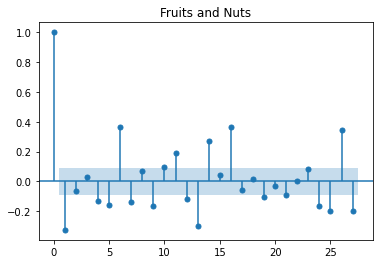

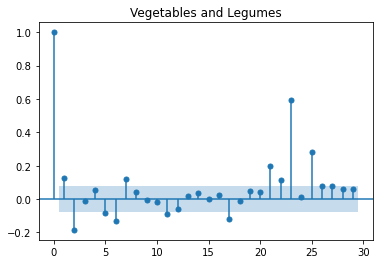

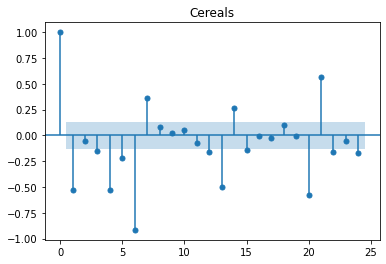

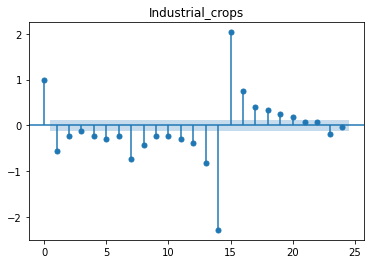

In [71]:
for cat in cat_names:
    crop_df = main_df[main_df['Category'] == cat]
    plot_pacf(crop_df['Yield(tonnes/ha)'], title= cat)


In [72]:
main_df['Category'].value_counts()

Vegetables and Legumes    670
Fruits and Nuts           450
Industrial_crops          237
Cereals                   217
Name: Category, dtype: int64

In [73]:
list(main_df.columns)

['Nutrient nitrogen N (total) - tonnes',
 'Nutrient phosphate P2O5 (total) - tonnes',
 'Nutrient potash K2O (total) - tonnes',
 'Item',
 'Yield(tonnes/ha)',
 'Fung & Bact – Benzimidazoles',
 'Fung & Bact – Diazines, morpholines',
 'Fung & Bact – Dithiocarbamates',
 'Fung & Bact – Inorganics',
 'Fung & Bact – Other',
 'Fung & Bact – Triazoles, diazoles',
 'Herbicides – Amides',
 'Herbicides – Carbamates',
 'Herbicides – Dinitroanilines',
 'Herbicides – Other',
 'Herbicides – Phenoxy hormone products',
 'Herbicides – Triazines',
 'Herbicides – Urea derivates',
 'Insecticides – Botanical products and biologicals',
 'Insecticides – Carbamates',
 'Insecticides – Organo-phosphates',
 'Insecticides – Other',
 'Insecticides – Pyrethroids',
 'Mineral Oils',
 'Plant Growth Regulators',
 'Rodenticides – Other',
 'Herbicides – Bipiridils',
 'Herbicides – Sulfonyl ureas',
 'Rodenticides – Anti-coagulants',
 'Category',
 'Crop_season',
 'Nutrient nitrogen N (total) - tonnes-1',
 'Nutrient nitrogen N

In [74]:
main_df.to_csv('latest_2504.csv', index=True)

In [75]:
# #main_df = pd.DataFrame(columns= df.columns)
# main_df = pd.DataFrame()

# for cate in cat_names: 
#     crop_df = df[df["Category"] == cate]
#     #first_diff = crop_df['Yield(tonnes/ha)']
#     adf_result = adfuller(crop_df['Yield(tonnes/ha)'])
#     while adf_result[1] > 0.05:
#         print ('Time series is NOT stationary')
#         #first_diff = first_diff.diff().dropna()
#         crop_df['Yield(tonnes/ha)'] = crop_df['Yield(tonnes/ha)'].diff()
#         crop_df = crop_df.dropna()
#         adf_result = adfuller(crop_df['Yield(tonnes/ha)'])

#     # Shift the minimum value to zero
#     min_val = crop_df['Yield(tonnes/ha)'].min()
#     crop_df['Yield(tonnes/ha)'] = (crop_df['Yield(tonnes/ha)'] - min_val) + 1e-6
#     #crop_df = crop_df.dropna(subset=["Yield(tonnes/ha)"])
#     for i in range(1, 4):
#         crop_df[f'yield_t-{i}'] = crop_df['Yield(tonnes/ha)'].shift(i)
#     crop_df = crop_df.dropna() 
#     main_df = pd.concat([main_df, crop_df])

# main_df
    



In [76]:
main_df.to_csv('latest_2504.csv', index=True)

NameError: name 'crop_names' is not defined

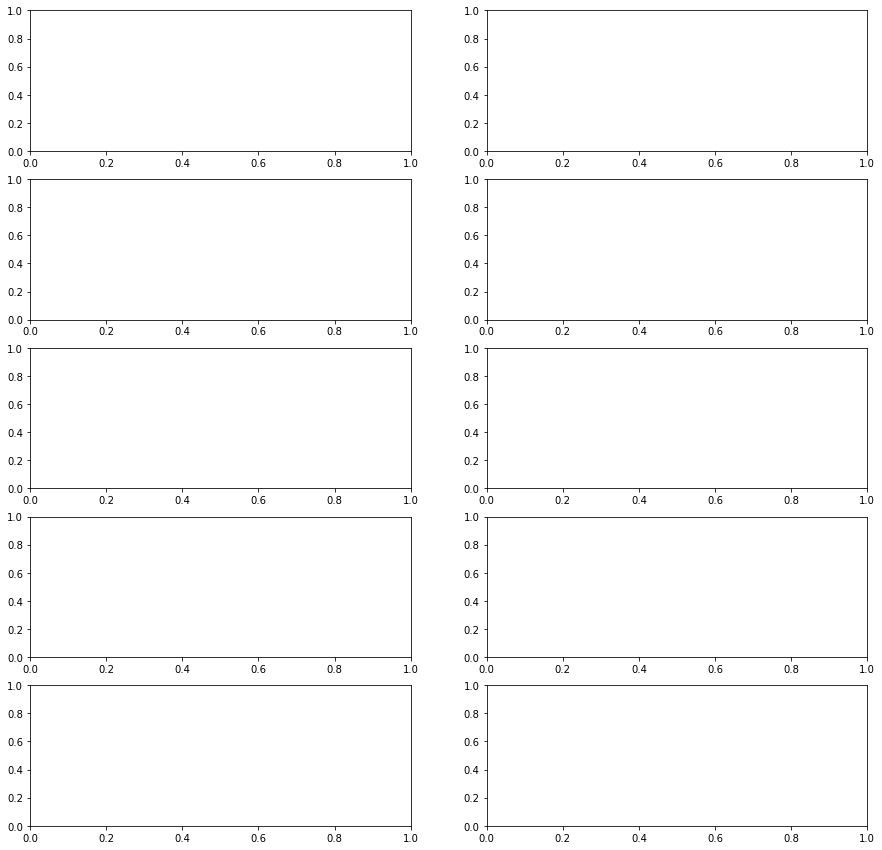

In [77]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15) )
count = 0
for crop in crop_names:
    crop_df = main_df[main_df["Item"] == crop]
    year_list = crop_df.index
    yield_data = crop_df["Yield(tonnes/ha)"]
    
    # Determine the row and column indices of the subplot
    row_idx = count % 5
    col_idx = count // 5
    
    # Select the appropriate subplot
    ax = axs[row_idx, col_idx]
    
    # Plot the yield data for the current item on the subplot
    ax.plot(year_list, yield_data, label=crop)
    
    # Set the title and axis labels for the subplot
    ax.set_title(crop)
    ax.set_xlabel('Year')
    ax.set_ylabel('Yield')
    
    # Add a legend to the subplot
    ax.legend()
    
    # change axis
    count +=1

plt.subplots_adjust(wspace=0.2, hspace=0.5)
# Show the figure
plt.show()

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# pd.options.mode.chained_assignment = None  # default='warn'
# # Loop over each independent variable and plot against the dependent variable
# for crop in crop_names:
#     crop_df = df[df["Item"] == crop]
    
#     # convert the 'year' column to datetime
#     crop_df['Year'] = pd.to_datetime(crop_df['Year'], format='%Y')
#     crop_df.set_index("Year", inplace=True)

#     decomp_add = seasonal_decompose(crop_df["Yield(tonnes/ha)"], model="additive", period=1)
    
#     plt.rcParams.update({'figure.figsize': (8,6)})
#     decomp_add.plot().suptitle(f'Additive Decomposition {crop}', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

#     decomp_mult = seasonal_decompose(crop_df["Yield(tonnes/ha)"], model="additive", period=1)
  
#     plt.rcParams.update({'figure.figsize': (8,6)})
#     decomp_mult.plot().suptitle(f'Multiplicative Decomposition {crop}', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

    

In [ ]:
# for crop in non_stat:
#     crop_df = df[df["Item"] == crop]

#     y = crop_df['Yield(tonnes/ha)']   
#     first_diff = y.copy().diff()
#     first_diff = first_diff.dropna()
#     adf_result = adfuller(pd.DataFrame(first_diff))
#     while adf_result[1] > 0.05:
#         print ('Time series is NOT stationary')
#         first_diff = first_diff.copy().diff()
#         first_diff = first_diff.dropna()
#         adf_result = adfuller(pd.DataFrame(first_diff))
    
#     plot_pacf(first_diff, lags=10)
    
    
    


In [ ]:

for crop in non_stat: 
    crop_df = df[df["Item"] == crop]
    first_diff = crop_df["Yield (tonnes/ha)"].copy().diff()
    first_diff = first_diff.dropna()

    plot_pacf(first_diff)

In [ ]:
#create a sliding window with a window size of 3

lagged_df = pd.DataFrame()
for crop in crop_names:
    crop_df = df[df["Item"] == crop]
    for i in range(1, 4):
        crop_df[f'yield_t-{i}'] = crop_df['Yield(tonnes/ha)'].shift(i)
    crop_df = crop_df.dropna()
    lagged_df = pd.concat([lagged_df, crop_df], axis=0)
  
    


In [ ]:
lagged_df['Item'].value_counts()

Barley                28
Cabbages              28
Maize (corn)          28
Potatoes              28
Rape or colza seed    28
Rye                   28
Sugar beet            28
Wheat                 28
Grapes                27
Apples                26
Name: Item, dtype: int64

In [ ]:
df.to_csv("master_data_TS.csv")
    

In [ ]:
df.columns

Index(['Nutrient nitrogen N (total) - tonnes',
       'Nutrient phosphate P2O5 (total) - tonnes',
       'Nutrient potash K2O (total) - tonnes', 'Item', 'Yield(tonnes/ha)',
       'Fung & Bact – Benzimidazoles', 'Fung & Bact – Diazines, morpholines',
       'Fung & Bact – Dithiocarbamates', 'Fung & Bact – Inorganics',
       'Fung & Bact – Other', 'Fung & Bact – Triazoles, diazoles',
       'Herbicides – Amides', 'Herbicides – Carbamates',
       'Herbicides – Dinitroanilines', 'Herbicides – Other',
       'Herbicides – Phenoxy hormone products', 'Herbicides – Triazines',
       'Herbicides – Urea derivates',
       'Insecticides – Botanical products and biologicals',
       'Insecticides – Carbamates', 'Insecticides – Organo-phosphates',
       'Insecticides – Other', 'Insecticides – Pyrethroids', 'Mineral Oils',
       'Plant Growth Regulators', 'Rodenticides – Other',
       'Herbicides – Bipiridils', 'Herbicides – Sulfonyl ureas',
       'Rodenticides – Anti-coagulants', 'yield_t-1